In [1]:
from tqdm import tqdm
import pandas as pd

#trigram bigram and trigram count
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from textblob import TextBlob
from transformers import BertTokenizer, BertModel
from string import punctuation
import torch

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
train = pd.read_csv('/content/drive/MyDrive/data_sets_v2/train.csv')
valid = pd.read_csv('/content/drive/MyDrive/data_sets_v2/valid.csv')
test = pd.read_csv('/content/drive/MyDrive/data_sets_v2/test.csv')

In [ ]:
#text features

#get bigrams and trigrams for each transcription
#use only bigrams/trigrams from training set and use trained vectorizer on test/valid sets

def get_ngrams(train_text):
  vectorizer= CountVectorizer(ngram_range=(2,3), max_features=1000)
  bigram_trigram = vectorizer.fit_transform(train_text)
  bigram_trigram_df = pd.DataFrame(bigram_trigram.toarray(), columns=vectorizer.get_feature_names_out())
  return bigram_trigram_df, vectorizer

def get_ngrams_test_or_valid(text, vectorizer):
    bigram_trigram = vectorizer.transform(text)
    bigram_trigram_df = pd.DataFrame(bigram_trigram.toarray(), columns=vectorizer.get_feature_names_out())
    return bigram_trigram_df

#count of each tags
def get_pos_tags(text):
  #split each element in DF into a list of strings
  pos_counts=[]
  for transcript in tqdm(text, desc="Processing POS tags"):
    #tokenize each transcript
    tokens = nltk.word_tokenize(transcript)
    #get pos tag
    pos_tags = nltk.pos_tag(tokens)
    pos_counts.append(nltk.FreqDist(tag for (word, tag) in pos_tags))
  pos_counts_df= pd.DataFrame(pos_counts)
  # Fill NaNs with 0 for missing POS tags
  pos_counts_df = pd.DataFrame(pos_counts).fillna(0)
  return pos_counts_df

#sentiment analysis
def get_sentiment(text):
  sentiments=[]
  for transcript in tqdm(text, desc="Processing Sentiments"):
    blob = TextBlob(transcript)
    subjectivity = blob.sentiment.subjectivity
    polarity= blob.sentiment.polarity
    sentiments.append({'subjectivity': subjectivity, 'polarity': polarity})
  sentiments_df = pd.DataFrame(sentiments)
  return sentiments_df

#punctuation
def get_punctuation(text):
  punctuation_counts=[]
  for transcript in tqdm(text, desc="Processing Punctuation"):
    punctuation_count = {
        'question_marks': transcript.count('?'),
        'exclamation_marks': transcript.count('!'),
        'commas': transcript.count(','),
        'periods': transcript.count('.'),
        'colons': transcript.count(':'),
        'semicolons': transcript.count(';')
    }
    punctuation_counts.append(punctuation_count)
  return pd.DataFrame(punctuation_counts)

#BERT embeddings
def get_bert_embeddings(text):
  #Load BERT tokenizer and model
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  model = BertModel.from_pretrained('bert-base-uncased')
  embeddings=[]
  for transcript in tqdm(text, desc="Processing BERT Embeddings"):
    #tokenize, make BERT inputs
    tokens= tokenizer(transcript, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
      outputs = model(**tokens)
    last_hidden_states = outputs.last_hidden_state[:,0,:].numpy()
    #make sure embeddings is a 1D vector, only want the CLS token
    embeddings.append(last_hidden_states.flatten())
    simple_embeddings = [embedding.mean() for embedding in embeddings]
  return pd.DataFrame(simple_embeddings, columns=['BERT_Embeddings_Mean'])


def get_all_features(data_set, vectorizer=None):
  text = data_set['transcript']
  print("Generating N-grams")
  if vectorizer==None:
    bigram_trigram_features, vectorizer = get_ngrams(text)
  else:
    bigram_trigram_features = get_ngrams_test_or_valid(text, vectorizer)
  print("Generating POS tags")
  pos_tags = get_pos_tags(text)
  print("Generating Sentiments")
  sentiments = get_sentiment(text)
  print("Generating Punctuation Counts")
  punctuation = get_punctuation(text)
  print("Generating BERT Embeddings")
  print("BERT OMITTED FOR TIME SAKE")
  #bert = get_bert_embeddings(text)
  features_set=pd.concat([data_set, bigram_trigram_features, pos_tags, sentiments, punctuation], axis=1)
  return features_set, vectorizer


data_set=train
print("Loading Train Features")
train_data, vectorizer = get_all_features(data_set)
train_data.to_csv('text_features_train.csv')
print("Train CSV Created")

data_set=test
print("Loading Test Features")
test_data, _ =get_all_features(data_set, vectorizer=vectorizer)
test_data.to_csv('text_features_test.csv')

print("Test CSV Created")

data_set=valid
print("Loading Valid Features")
valid_data, _ =get_all_features(data_set, vectorizer=vectorizer)
valid_data.to_csv('text_features_valid.csv')
print("Valid CSV Created")

Loading Train Features
Generating N-grams
Generating POS tags


Processing POS tags: 100%|██████████| 83971/83971 [00:54<00:00, 1527.12it/s]


Generating Sentiments


Processing Sentiments: 100%|██████████| 83971/83971 [00:16<00:00, 5095.64it/s]


Generating Punctuation Counts


Processing Punctuation: 100%|██████████| 83971/83971 [00:00<00:00, 614269.30it/s]


Generating BERT Embeddings
BERT OMITTED FOR TIME SAKE
Train CSV Created
Loading Test Features
Generating N-grams
Generating POS tags


Processing POS tags: 100%|██████████| 23540/23540 [00:14<00:00, 1670.26it/s]


Generating Sentiments


Processing Sentiments: 100%|██████████| 23540/23540 [00:06<00:00, 3796.06it/s]


Generating Punctuation Counts


Processing Punctuation: 100%|██████████| 23540/23540 [00:00<00:00, 331598.94it/s]


Generating BERT Embeddings
BERT OMITTED FOR TIME SAKE
Test CSV Created
Loading Valid Features
Generating N-grams
Generating POS tags


Processing POS tags: 100%|██████████| 21632/21632 [00:14<00:00, 1450.55it/s]


Generating Sentiments


Processing Sentiments: 100%|██████████| 21632/21632 [00:03<00:00, 6070.96it/s]


Generating Punctuation Counts


Processing Punctuation: 100%|██████████| 21632/21632 [00:00<00:00, 326190.47it/s]


Generating BERT Embeddings
BERT OMITTED FOR TIME SAKE
Valid CSV Created


In [ ]:
!pip install praat-parselmouth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 94.5 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import parselmouth as pm
from parselmouth.praat import call
import numpy as np

In [ ]:
# Load datasets
train = pd.read_csv('/content/drive/MyDrive/data_sets_v2/train.csv')
valid = pd.read_csv('/content/drive/MyDrive/data_sets_v2/valid.csv')
test = pd.read_csv('/content/drive/MyDrive/data_sets_v2/test.csv')

#Function to load only the sounds that match the dataset requirements
def get_sounds(directory, dataset):
    samples = [f for f in os.listdir(directory) if f.endswith('.wav')]
    required_names = set(f"{row['dialog_id']}_{row['speaker']}" for _, row in dataset.iterrows())
    sounds = {os.path.splitext(f)[0]: pm.Sound(os.path.join(directory, f))
          for f in tqdm(samples, desc="Loading sounds") if os.path.splitext(f)[0] in required_names}
    return sounds

#Extract features for a sound segment
def extract_features_segment(name, segment, start_time, end_time):
    data = {
        "dialog_id": name.split('_')[0],
        "speaker": name.split('_')[1]
    }

    #Initialize variables that will be used later (ensure no errors if not there)
    pitch = None
    point_process = None
    formants = None

    #use try catch to make sure keeps running extraction even if errors occur
    #errors occur usually when a segment is too short to extract features
    try:
        pitch = call(segment, "To Pitch (ac)...", 0.0, 75.0, 15, "off", 0.09, 0.5, 0.055, 0.35, 0.14, 600.0)
        data["Min Pitch"] = call(pitch, "Get minimum...", 0.0, 0.0, "Hertz", "Parabolic")
        data["Max Pitch"] = call(pitch, "Get maximum...", 0.0, 0.0, "Hertz", "Parabolic")
        data["Mean Pitch"] = call(pitch, "Get mean...", 0.0, 0.0, "Hertz")
    except pm.PraatError as e:
        print(f"Error calculating pitch for segment {name}: {e}")

    try:
        if (end_time - start_time) < 0.064:
            data["Mean Intensity"] = 0
            print("Intensity Zero")
        else:
            intensity = call(segment, "To Intensity...", 100.0, 0.0, "yes")
            data["Mean Intensity"] = call(intensity, "Get mean...", 0.0, 0.0, "Energy")
    except pm.PraatError as e:
        print(f"Error calculating intensity for segment {name}: {e}")

    try:
        #make sure pitch was successfully calculated
        if pitch is not None:
            point_process = call(pitch, "To PointProcess")
            data["Jitter"] = call(point_process, "Get jitter (local)", 0.0, 0.0, 0.0001, 0.02, 1.3)
            data["Shimmer"] = call([segment, point_process], "Get shimmer (local)", 0.0, 0.0, 0.0001, 0.02, 1.3, 1.6)
    except pm.PraatError as e:
        print(f"Error calculating jitter or shimmer for segment {name}: {e}")

    try:
        hnr = call(segment, "To Harmonicity (cc)...", 0.01, 75, 0.1, 1.0)
        data["HNR"] = call(hnr, "Get mean", 0.0, 0.0)
    except pm.PraatError as e:
        print(f"Error calculating HNR for segment {name}: {e}")

    try:
        #make sure have point process
        #followed tutorial:
        #http://blog.syntheticspeech.de/2021/03/10/how-to-extract-formant-tracks-with-praat-and-python/
        if point_process is not None:
            formants = call(segment, "To Formant (burg)...", 0.0, 5, 5500, 0.025, 50)
            numPoints = call(point_process, "Get number of points")
            f1_list, f2_list, f3_list = [], [], []
            for point in range(numPoints):
                t = call(point_process, "Get time from index", point + 1)
                f1 = call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
                f2 = call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
                f3 = call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
                if f1 > 0 and not np.isnan(f1):
                    f1_list.append(f1)
                if f2 > 0 and not np.isnan(f2):
                    f2_list.append(f2)
                if f3 > 0 and not np.isnan(f3):
                    f3_list.append(f3)
            #only use means, long vectors arent helpful
            data["Mean F1"] = np.mean(f1_list) if f1_list else 0
            data["Mean F2"] = np.mean(f2_list) if f2_list else 0
            data["Mean F3"] = np.mean(f3_list) if f3_list else 0
    except pm.PraatError as e:
        print(f"Error calculating formants for segment {name}: {e}")

    return data

#Extract features for each time segment in sounds
def get_speech_features(dataset, sounds):
    features_data = []
    for _, row in tqdm(dataset.iterrows(), desc="Extracting Features", total=dataset.shape[0]):
        dialog_id = row['dialog_id']
        speaker = row['speaker']
        start_time = row['start_time']
        end_time = row['end_time']

        name = f"{dialog_id}_{speaker}"
        if name in sounds:
            sound = sounds[name]
            #Extract the segment between start_time and end_time
            segment = sound.extract_part(from_time=start_time, to_time=end_time, preserve_times=True)
            #Extract features for the segment and add the time frame
            features = extract_features_segment(name, segment, start_time, end_time)
            features["start_time"] = start_time
            features["end_time"] = end_time

            #Add the features to the list
            features_data.append(features)

    return pd.DataFrame(features_data)

def merge_with_dataset(data_set, speech_features):
    #Keep only the first 6 columns of the dataset and merge on 'dialog_id', 'speaker', 'start_time', and 'end_time'
    data_set_subset = data_set.iloc[:, :6].copy()
    #chose to replace NaN with 0s when segment too short
    speech_features.fillna(0, inplace=True)
    #merge the features with the dataset subset
    merged_data = pd.merge(data_set_subset, speech_features,
                           how="left", on=['dialog_id', 'speaker', 'start_time', 'end_time'])
    return merged_data

def main():
    directory = "/content/drive/MyDrive/wav"

    #Process train dataset
    print("Loading Train Features")
    train_sounds = get_sounds(directory, train)
    train_speech_features = get_speech_features(train, train_sounds)
    train_data = merge_with_dataset(train, train_speech_features)
    train_data.to_csv('speech_features_train.csv', index=False)
    print("Train CSV Created")

    #Process test dataset
    print("Loading Test Features")
    test_sounds = get_sounds(directory, test)
    test_speech_features = get_speech_features(test, test_sounds)
    test_data = merge_with_dataset(test, test_speech_features)
    test_data.to_csv('speech_features_test.csv', index=False)
    print("Test CSV Created")

    #Process valid dataset
    print("Loading Valid Features")
    valid_sounds = get_sounds(directory, valid)
    valid_speech_features = get_speech_features(valid, valid_sounds)
    valid_data = merge_with_dataset(valid, valid_speech_features)
    valid_data.to_csv('speech_features_valid.csv', index=False)
    print("Valid CSV Created")

if __name__ == "__main__":
    main()

Loading Train Features


Loading sounds:  67%|██████▋   | 677/1016 [00:52<00:29, 11.35it/s]

NOTE: I found my laptop was able to extract the speech_features faster than on Google Colab, so I ran it locally. Google Colab crashed many times and was not as reliable. Here are the associated outputs from my terminal. Please see images below. Thank you for your understanding.

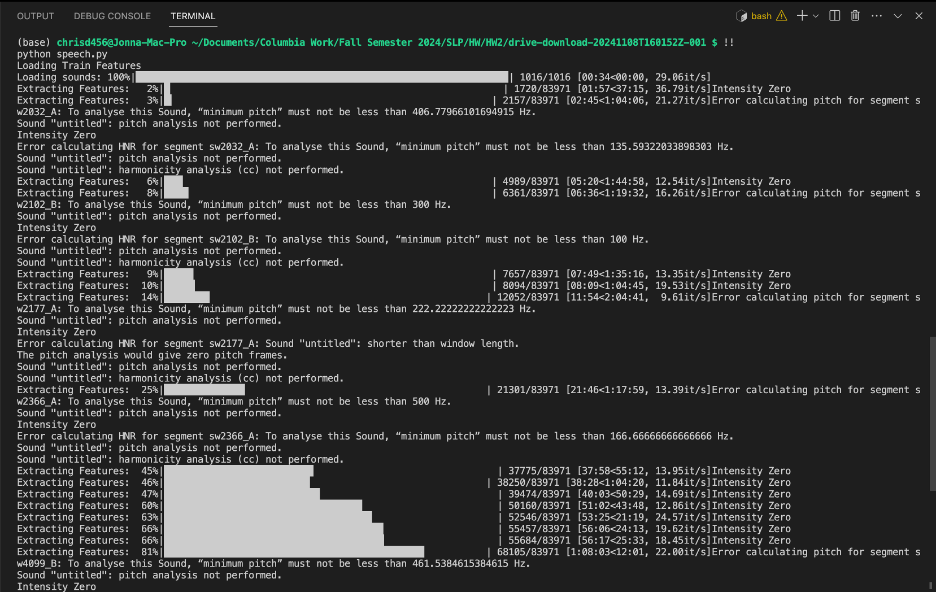

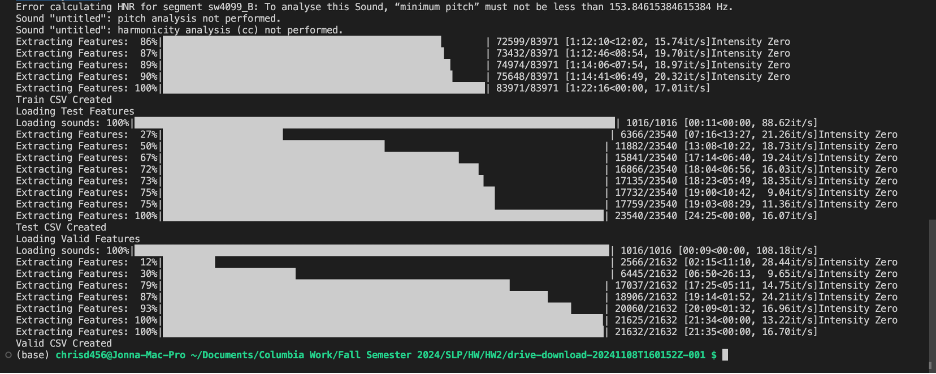

2. For each custom feature set (text-feature set and speech feature set),
formulate and test a hypothesis about one of the features (visually or
statistically). Observe if the results are in accordance with your hypothesis or
not. Give an explanation about your thinking behind the observed behavior.
For example, testing whether the LIWC feature “Insight”, which is associated
with words such as “think” and “know”, or the bigram “I think” are useful in
predicting the dialogue act “Statement-opinion”. This hypothesis could be
tested by plotting average values of the LIWC “insight” features or “I think”
bigram for the top 10 dialogue acts

In [ ]:
#filter out to only have top 10 tags
ten_tags=['sd', 'b', 'sv', 'aa', '%', 'ba', 'qy', 'x', 'ny', 'fc']

In [ ]:
#Text feature plot
text_train_df = pd.read_csv('/content/drive/MyDrive/data_sets_v2/text_features_train.csv')
train_filtered_text_features = text_train_df[text_train_df['da_tag'].isin(ten_tags)]
train_filtered_text_features.head()

,Unnamed: 0,dialog_id,speaker,transcript,da_tag,start_time,end_time,function,pronoun,ppron,...,(,),subjectivity,polarity,question_marks,exclamation_marks,commas,periods,colons,semicolons
1,1,sw2005,B,SIL,x,0.00000,10.94882,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.00,0,0,0,0,0,0
3,3,sw2005,A,SIL,x,10.93013,21.35084,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.00,0,0,0,0,0,0
4,4,sw2005,B,well of course it's you know it's one of the l...,sv,10.94882,22.28000,0.642857,0.285714,0.190476,...,0.0,0.0,0.393333,0.26,0,0,0,0,0,0
5,5,sw2005,A,yes,b,21.35084,22.08088,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.00,0,0,0,0,0,0
6,6,sw2005,A,SIL,x,22.08088,44.96288,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.00,0,0,0,0,0,0


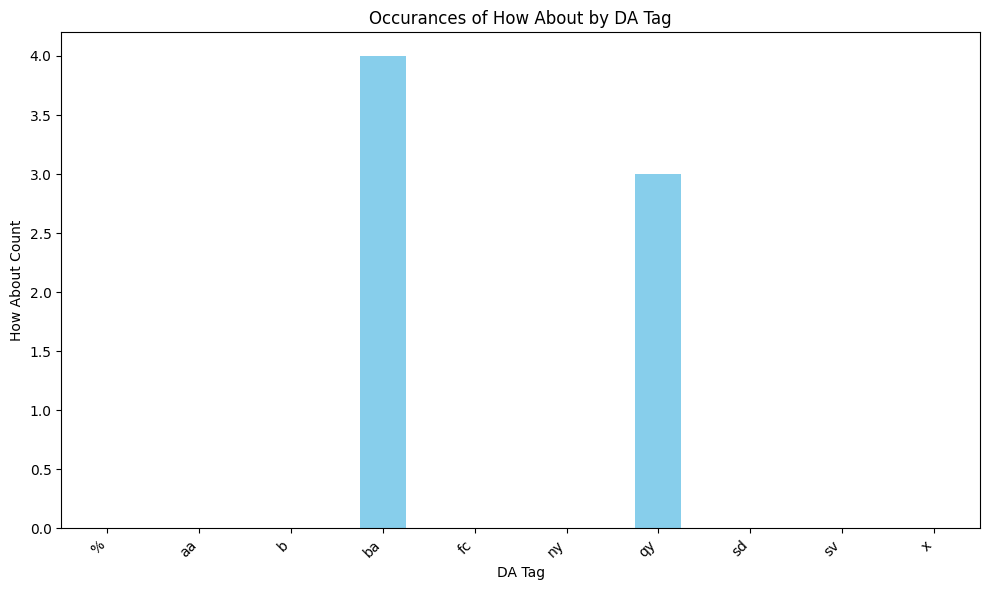

In [ ]:
df=train_filtered_text_features
#group by 'da_tag' and calculate the total how about occurances for each tag
periods_by_da_tag = df.groupby('da_tag')['how about'].sum()

#plot label occurences against bigram frequency
plt.figure(figsize=(10, 6))
periods_by_da_tag.plot(kind='bar', color='skyblue')
plt.title('Occurances of How About by DA Tag')
plt.xlabel('DA Tag')
plt.ylabel('How About Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
speech_train_df= pd.read_csv('/content/drive/MyDrive/data_sets_v2/speech_features_train.csv')
speech_train_df = pd.read_csv('/content/drive/MyDrive/data_sets_v2/speech_features_train.csv')
train_filtered_speech_features = speech_train_df[speech_train_df['da_tag'].isin(ten_tags)]
train_filtered_speech_features.head()

,dialog_id,speaker,transcript,da_tag,start_time,end_time,Min Pitch,Max Pitch,Mean Pitch,Mean Intensity,Jitter,Shimmer,HNR,Mean F1,Mean F2,Mean F3
1,sw2005,B,SIL,x,0.00000,10.94882,87.138127,172.738116,119.167693,37.469195,0.007124,0.113189,10.592658,683.870096,1299.487080,1994.745783
3,sw2005,A,SIL,x,10.93013,21.35084,79.164788,575.099918,119.517486,33.448030,0.010270,0.122509,6.452603,572.094419,1339.140796,2349.811998
4,sw2005,B,well of course it's you know it's one of the l...,sv,10.94882,22.28000,76.503924,575.932033,121.301986,50.496110,0.011517,0.113635,8.886724,619.888032,1327.187843,2242.473999
5,sw2005,A,yes,b,21.35084,22.08088,98.272004,118.833448,107.286728,53.496582,0.008972,0.104630,10.746552,487.839443,1584.146765,1957.017485
6,sw2005,A,SIL,x,22.08088,44.96288,75.420186,537.835926,106.134515,35.071266,0.009622,0.104350,8.540437,535.840992,1360.030135,2250.272020


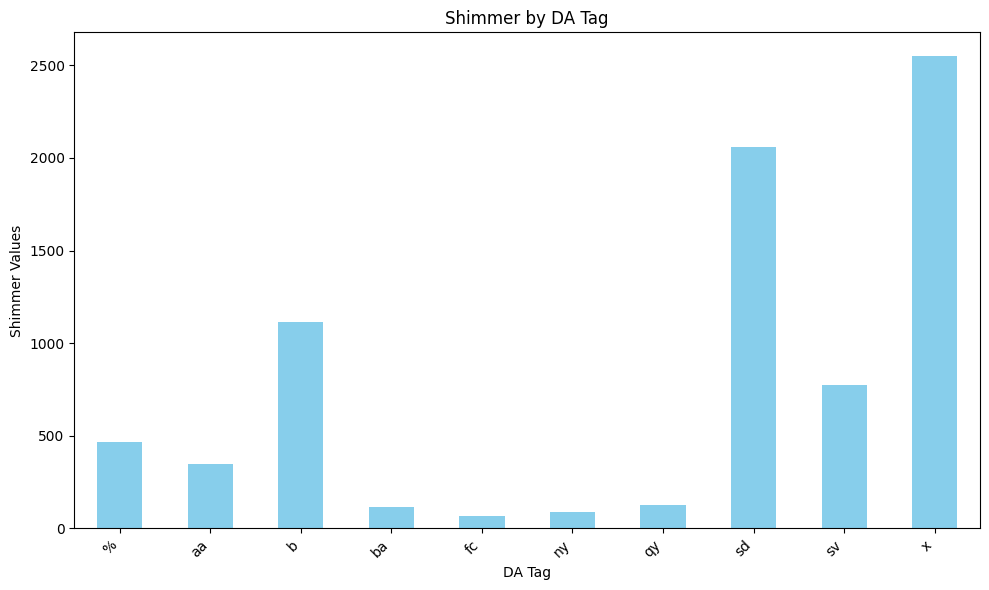

In [ ]:
df=train_filtered_speech_features
#group by 'da_tag' and shimmer for each tag
periods_by_da_tag = df.groupby('da_tag')['Shimmer'].sum()

#plot label occurences against shimmer for each tag
plt.figure(figsize=(10, 6))
periods_by_da_tag.plot(kind='bar', color='skyblue')
plt.title('Shimmer by DA Tag')
plt.xlabel('DA Tag')
plt.ylabel('Shimmer Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()